<center><h1> PyF2F - Estimate Distances Notebook </h1></center>

This notebook follows an example of PyF2F-Ruler's workflow from start to finish to estimate the distance between two fluorophores labeling the two subunits of the exocyst complex: Exo70 (C-terminal) and Sec5 (C-terminal). This distances was used, together with a whole set of distances, to compute the 3D architecture of the exocyst complex [Picco et al., 2017](https://www.sciencedirect.com/science/article/pii/S0092867417300521) 

Workflow: a set of ~ 30 two channel images (corresponding to the two labelled subunits) are processed and analysed to estimate the distance between the two fluorophores. For more information see our paper (*link*).

### Scientific IPython Setup

Before starting, we need to :
1. Scientific IPython Setup
2. Set parameters to run the distance estimation workflow
3. Set paths to working directories

<h3>1. Scientific IPython Setup </h3>

Load some required scientific Python libraries:

In [5]:
%load_ext autoreload
%autoreload 2
import os
import glob
import shutil
import sys
import time
import pandas as pd
import numpy as np
import trackpy as tp
import pims
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tkinter as tk
from tkinter import filedialog
from pymicro.view.vol_utils import compute_affine_transform
from matplotlib import rcParams
from skimage import io, util
from skimage import data
from scipy import stats
from scipy import spatial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


as well as PyF2F-Ruler's custom functions:

In [2]:
# Append PyF2F scripts path and import functions
sys.path.append(os.getcwd() + '/scripts/')
from calculate_PICT_distances import *
from detect_beads import *
%aimport detect_beads
%aimport calculate_PICT_distances

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


<h3>2. Parameters </h3>

Now, we have to set the **parameters** to run the image registration workflow:

In [3]:
###############
# PARAMETERS
###############
# Pixel size of the camera
px_size = 110             # Zyla camera (64.5 nm/px) // Prime camera (110 nm/px) 
####################
# 1. Pre-processing
####################
rbr = 41                  # BGN Subtraction (rolling ball radius) 
mfr = 6                   # BGN Subtraction (median filter radius)
###################
# Spot Detection
###################
sdd = 7                   # Spot Detection (diameter of the spot (~ 2·PSF))
sdpc = 99.7               # Spot Detection (select spot intensities above this percentile)
sdl = 1                   # Spot Detection (max separation to link c1-c2 spots)

############################# 
# YC Segmentation 
# (YeastSpotter parameters)
#############################

rescale = False           # Set to true to rescale the input images to reduce segmentation time
scale_factor = 2          # Factor to downsize images by if rescale is True
save_preprocessed = True  # save preprocessed images as input to neural network
save_compressed = False   # Set to true to save a compressed RLE version of the masks for sharing
save_masks = True         # Set to true to save the full masks
verbose = True            # print out its segmentation progress as it proceeds
output_imagej = False     # Set to true to output ImageJ-compatible masks
save_contour = True       # Save contour images
save_contour_mod = True   # Save contour modified images

###################
# Spot Selection
###################
ccmd = 7                  # Cell Contour (max distance)
cnmd = sdd - 1            # Closest neighbour (min distance)
kde = 0.5                 # 2D-KDE cutoff (density prob. between 0 - 1)
gauss = 0.35              # gaussian cutoff (R² between 0 - 1)
rjlw = 0                  # reject distances lower thant this (in nm)

###################
# MLE
###################
mle_cutoff = 2/3          # % of distance distribution assumed to be ok.

<h3>3. Set paths to your working directories </h3>

The last thing to go is setting the paths to the working directories. We advise to create a directory to work with. In this example we create a directory called **Exo70_Sec5**. Then we should indicate where are located 1) Beads for registration, 2) Beads for test, and 3) Sample images (PICT images). The following cell takes care of asking us to select: 

- **Working directory**
- Directory with beads images to create the registration map (**Beads_reg**)
- Directory with beads images to calculate the error of registration (**Beads_test**)
- Directory with sample images (**PICT images**)

In [7]:
# Select working directories:
root = tk.Tk()
root.withdraw()
working_directory = filedialog.askdirectory(title="Select Working Directory") + "/"
path_beads_reg = filedialog.askdirectory(title="Select Directory Beads Registration") + "/"
path_beads_test = filedialog.askdirectory(title="Select Directory Beads Test") + "/"
sample_directory = filedialog.askdirectory(title="Select PICT Images Directory") + "/"

# Create directories for output and organize working directory
# Input Dir
path_to_input = working_directory + "input/"
if not os.path.exists(path_to_input):
    os.mkdir(path_to_input)
# Output Dir
path_to_output = working_directory + "output/"
if not os.path.exists(path_to_output):
    os.mkdir(path_to_output)
# Output Reg Beads Dir
path_output_reg = path_to_input + "output_reg/"
if not os.path.exists(path_output_reg):
    os.mkdir(path_output_reg)
# Output Test Beads Dir
path_output_test = path_to_input + "output_test/"
if not os.path.exists(path_output_test):
    os.mkdir(path_output_test)
# PICT images directory
path_to_pict_images = path_to_input + "pict_images/"
if not os.path.exists(path_to_pict_images):
    os.mkdir(path_to_pict_images)
# Copy PICT images to the defined directory path_to_input + "pict_images/"
for pict_image in glob.glob(sample_directory + "*.tif"):
    img_name = pict_image.split("/")[-1]
    shutil.copyfile(pict_image, path_to_pict_images + img_name)

##################
# PATHS TO OUTPUT
##################
path_to_pp = path_to_output + "images/"             # To save pre-processed images
path_to_spot_detection = path_to_output + "spots/"  # To save Spot Detection results in CSV format
path_to_results = path_to_output + "results/"       # To save relevant result files in CSV format
path_to_figures = path_to_output + "figures/"       # To save figures in PDF, PNG and HTML format
path_to_segment = path_to_output + "segment/"       # To save segmentations of cells

In [8]:
print("Your Paths: \n"
          " -Working directory: {}\n"
          " -Beads_Reg directory: {}\n"
          " -Beads_Test directory: {}\n"
          " -PICT images directory: {}\n"
          " -Output directory: {}\n".format(working_directory,
                                            path_beads_reg,
                                            path_beads_test,
                                            path_to_pict_images,
                                            path_to_output))  

Your Paths: 
 -Working directory: /home/altair/PycharmProjects/book_chapter_local_affine/Exo70_Sec5/
 -Beads_Reg directory: /home/altair/PycharmProjects/book_chapter_local_affine/F9/input/beads_registration_laura/
 -Beads_Test directory: /home/altair/PycharmProjects/book_chapter_local_affine/F9/input/beads_test_laura/
 -PICT images directory: /home/altair/PycharmProjects/book_chapter_local_affine/Exo70_Sec5/input/pict_images/
 -Output directory: /home/altair/PycharmProjects/book_chapter_local_affine/Exo70_Sec5/output/



Now we are ready to run the PyF2F workflow to **estimate the distance** between the **Exo70-mCherry** and the **Sec5-GFP** tags. Notice that all the results will be saved in the "output/" directory.

<h3>Step 1. Calculate Regitration Map</h3>

Get two channels (c1-c2) coordinates from the REF set of beads to calculate the registration map that will be used to register the two channels. If the coordinates have been previously calculated, then are loaded from the saved CSV files in the "output_reg" and "output_test" directories. This is the same protocol explained in the **PyF2F Image Registration** notebook.

In [9]:
######################
# 1. Get Coordinates
######################
# Beads Params
beads_head = "beads_*.tif"      # Beads_head (pattern in bead images)
px_size = 110                   # Zyla camera (64.5 nm/px) // Prime camera (110 nm/px) 
spot_diameter = 7               # spot detection: diameter of spots in px
percentile = 99.6               # spot detection: sort spots below this percentile of intensity 
min_mass = 0.01                 # spot detection: sort spots with a mass above this threshold (range 0-1). 
max_mass = 0.95                 # spot detection: sort spots with a mass below this threshold (range 0-1).
max_displacement=1              # linking: link spots from ch1-ch2 channels separated by this cutoff in px
search_range = 2000 // px_size  # local registration: max distance in px for nearest-neighbour search
min_fiducials = 100             # local registration: minimum number of fiducial markers to correct locally 

# Check if spots have been previously detected and saved in 
# the "path_output_reg" and "path_output_test" directories  
if os.path.exists(path_output_reg + "/coords_W1.csv") and os.path.exists(path_output_reg + "/coords_W2.csv"):
    c1_ref = np.loadtxt(path_output_reg + "/coords_W1.csv", delimiter=",")
    c2_ref = np.loadtxt(path_output_reg + "/coords_W2.csv", delimiter=",")
    c1_test = np.loadtxt(path_output_test + "/coords_W1.csv", delimiter=",")
    c2_test = np.loadtxt(path_output_test + "/coords_W2.csv", delimiter=",")
    
else:
    # Get coordinates from beads for registration
    c2_ref, c1_ref = get_coords(path_output_reg, path_beads_reg, beads_head, diameter=spot_diameter, separation=max_displacement, percentile=percentile, min_mass_cutoff=min_mass, max_mass_cutoff=max_mass, px_size=px_size)
    c2_test, c1_test = get_coords(path_output_test, path_beads_test, beads_head, diameter=spot_diameter, separation=max_displacement, percentile=percentile, min_mass_cutoff=min_mass, max_mass_cutoff=max_mass, px_size=px_size)

Frame 1: 91 trajectories present.


<h3>Step 2. Image Pre-processing and Spot Detection</h3>

- Pre-processing: Raw PICT images are background subtracted using the rolling ball algorithm. The uneven illumination of the cytoplasmic background is also smoothed by subtracting the median filter.

- Spot Detection: bright spots corresponding to the mCherry and GFP channels are detected in the two channels separately and then linked with a maximum separation parameter.

In [10]:
######################
# 2. Pre-processing 
######################
pp(path_to_pict_images, path_to_pp, rbr, mfr)

######################
# 3. Spot Detection 
###################### 
spot_detection(path_to_pp, path_to_spot_detection, path_to_results, path_to_figures, 
              sdd, sdpc, min_mass, max_mass, sdl, px_size=px_size)



Frame 1: 37 trajectories present.

Total Initial W1 Detected spots: 1591

Total Initial W2 Detected spots: 1563

Total Final Paired spots: 674



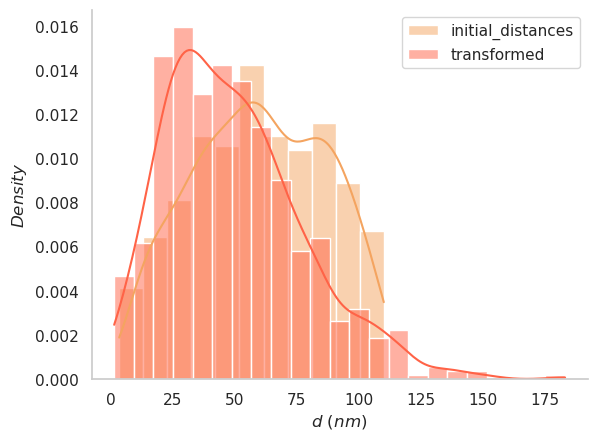

In [23]:
############################
# 4. Warping (registration) 
############################
local_warping(path_output_reg, path_to_spot_detection, path_to_figures, path_to_results, pixel_size=px_size)

<h3>Step 3. Spot Selection</h3>

- **Distance to the cell contour**: due to the experimental conditions of PICT, detected spots must be located at the plasma membrane of the cell. In this step, PyF2F-Ruler utilises YeastSpotter to determine the contour of the cell. Spots are sorted according to a maximum distance to the cell contour.

- **Spot pairs in focus**: for determining the distance between spot detected in the two channels, it is crucial to select only those spots that are in focus. Spot pairs in focus should share the same intensity properties. Here, PyF2F-Ruler selects spot pairs in focus by selecting those sharing simillar eccentricity (round spots) and second momentum of intensity.

- **Goodness of the gaussian fit**: the intensity profiles of the spot pairs should fit well with a 2D-gaussian function. The goodness of the gaussian fit evaluates the quality of detected spots according to this criteria.

In [24]:
###############################
# 5. Distance to Cell Contour 
###############################
total_data, seg_selected = main_segmentation(path_to_segment, path_to_pp, path_to_spot_detection,
                                             path_to_results,path_to_figures, scale_factor, ccmd,
                                             cnmd, rescale=rescale, verbose=True, px_size=px_size)
###############################
# 6. Spot Pairs in focus 
###############################
kde_initial, kde_selected = main_kde(path_to_pp, path_to_results, path_to_figures, kde_cutoff=kde, px_size=px_size)

##################################
# 7. Goodness of the Gaussian Fit 
##################################
gauss_initial, gauss_selected = main_gaussian(path_to_results, path_to_pp, path_to_figures, gaussian_cutoff=gauss, px_size=px_size)

#############################
 Segmentation Pre-processing 
#############################

Processing image Pos10 ...

	Sorting spots...

Image Pos10 processed in 0.239 s

Processing image Pos22 ...

	Sorting spots...

Image Pos22 processed in 0.217 s

Processing image Pos11 ...

	Sorting spots...

Image Pos11 processed in 0.213 s

Processing image Pos5 ...

	Sorting spots...

Image Pos5 processed in 0.238 s

Processing image Pos13 ...

	Sorting spots...

Image Pos13 processed in 0.216 s

Processing image Pos23 ...

	Sorting spots...

Image Pos23 processed in 0.237 s

Processing image Pos6 ...

	Sorting spots...

Image Pos6 processed in 0.321 s

Processing image Pos9 ...

	Sorting spots...

Image Pos9 processed in 0.232 s

Processing image Pos12 ...

	Sorting spots...

Image Pos12 processed in 0.263 s

Processing image Pos3 ...

	Sorting spots...

Image Pos3 processed in 0.296 s

Processing image Pos8 ...

	Sorting spots...

Image Pos8 processed in 0.244 s

Processing image Pos16 ...



<h3>Step 4. Distance Estimation</h3>

The last step of the workflow consists in determining the true distance between the two fluorescent labels by maximizing the accuracy and precision. At this point, we assume that the majority of the spot pairs are candidates to be real labels of the exocyst subunits Exo70 and Sec5. However, since it is known that the distance distribution is skewed towards large values, we assume that contaminants (outliers) may lie in that area. 

Here, PyF2F-Ruler performs a **maximum likelihood estimate (MLE)** to estimate the true distance $\mu$ between the two fluorophores. The MLE searches for the distance that maximizes the probability of the experimental distribution. Outliers are rejected with a **bootstrap method** (see supplementary information).  



####################################
Initializing Outlier rejection 
########################################



Choosing distance distribution median and stdev as initial values to start fitting..

	Initial mu: 38.66139681026706
	Initial sigma: 21.714522754634995

	Starting optimization...

-----OPTIM-----
mu : 1.06 +/- 38.48
sigma : 32.28 +/- 1.69

Starting search of outliers:

	Number of distances: 102
	Cutoff: Explore 33.33333333333333% of distance distribution
	Reject lower: 0 nm

...

-----OPTIM-----
mu : 0.68 +/- 478.75
sigma : 31.44 +/- 7.34
-----OPTIM-----
mu : 20.45 +/- 22.12
sigma : 27.06 +/- 8.34
-----OPTIM-----
mu : 27.56 +/- 5.12
sigma : 22.69 +/- 3.11
-----OPTIM-----
mu : 28.56 +/- 4.04
sigma : 21.37 +/- 2.71
-----OPTIM-----
mu : 29.22 +/- 3.6
sigma : 20.23 +/- 2.39
-----OPTIM-----
mu : 29.48 +/- 3.16
sigma : 19.44 +/- 2.16
-----OPTIM-----
mu : 29.6 +/- 5.88
sigma : 18.77 +/- 3.05
-----OPTIM-----
mu : 29.66 +/- 2.76
sigma : 18.17 +/- 1.87
-----OPTIM-----
mu : 29.65 +/-

<Figure size 2500x1500 with 0 Axes>

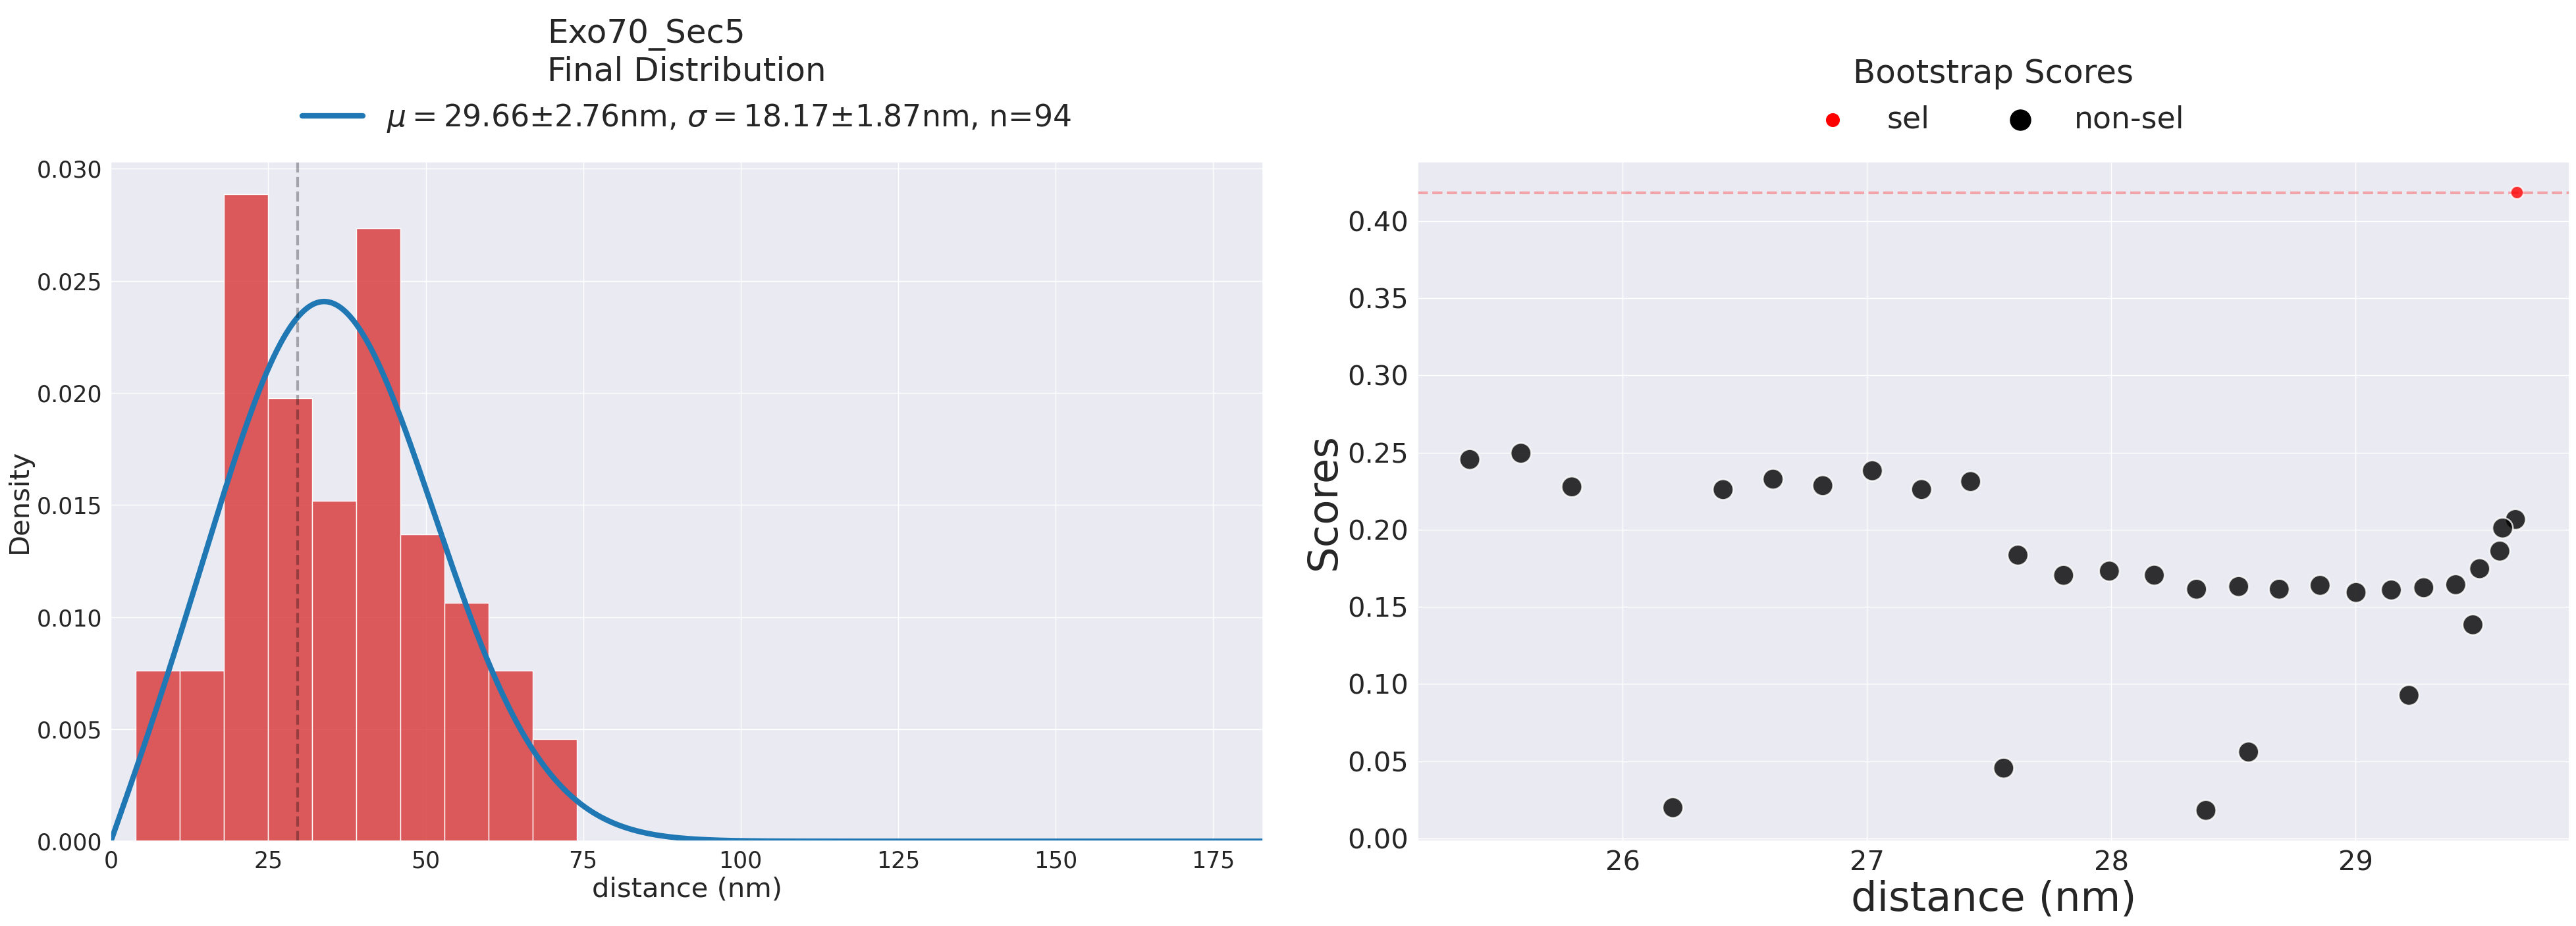

In [27]:
##################################
# 8. MLE and Outlier Rejection 
##################################
outlier_rejection(path_to_results, path_to_figures, path_to_pp, mu_ini=None, sigma_ini=None,
                  reject_lower=rjlw, cutoff=mle_cutoff)

## END